In [48]:
import numpy as np
import pandas as pd

def preprocess_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df[(df != "******").all(axis=1)]
    
    col_map = {
        "długośćmm": "dlugoscmm",
        "szerokośćmm": "szerokoscmm",
        "kąt": "kat",
        "obwódmm": "obwodmm",
        "średnica_fereta_hmm": "srednica_fereta_hmm",
        "średn._martinamm": "sredn._martinamm",
        "średn._sitowamm": "sredn._sitowamm",
        "średnia_jaskrawość": "srednia_jaskrawosc"
    }

    if "długośćmm" in df.columns:
        df = df.rename(columns=col_map)
        if "szerokoscmm" in df.columns:
            df["szerokoscmm"] = df["szerokoscmm"].astype(np.float64)

    return df


In [49]:
import pandas as pd
import cv2
import numpy as np

def process_one_image(CSV_PATH_CORRECT = 'KolejnyTest/5M/x/report_5_x.csv',CSV_PATH_PREDICTED = 'KolejnyTest/5M/x/report_5_x.csv',IMAGE_PATH = f'KolejnyTest/5M/x/a.jpg'   ,OUTPUT_PATH = f'KolejnyTest/5M/x/a_marked.jpg'):
    # === CONFIG ===
            # Path to the original image
        # Where to save the output image

    # === LOAD IMAGE AND DATA ===
    img = cv2.imread(IMAGE_PATH)
    df_real = preprocess_df(pd.read_csv(CSV_PATH_CORRECT))
    df_predicted = preprocess_df(pd.read_csv(CSV_PATH_PREDICTED))

    height, width = img.shape[:2]

    # === DRAW OBJECTS ===
    for i, row in df_real.iterrows():
        try:
            # Extract pixel coordinates
            x = int(row['xpix.'])
            y = int(row['ypix.'])
            
            # Extract size in mm → convert to pixels if needed (assuming 1mm = 10px for now, adjust as needed)
            width_mm = float(row['szerokoscmm'])
            height_mm = float(row['dlugoscmm'])
            angle = 90-float(row['kat'])  # OpenCV uses negative angle for rotation
            # angle = float(row['kat'])  # OpenCV uses negative angle for rotation

            mm_to_px = 10  # ⬅️ Adjust this scaling factor based on your image resolution

            width_px = int(width_mm * mm_to_px)
            height_px = int(height_mm * mm_to_px)

            # Draw ellipse representing the object
            center = (x, height-y)
            # axes = (1, 1)
            axes = (width_px // 2, height_px // 2)
            color = (0, 255, 0)  # Green
            thickness = 1

            cv2.ellipse(img, center, axes, angle, 0, 360, color, thickness)

            # Optional: draw ID
            cv2.putText(img, str(int(row['nr.'])), (x + 5, height - y - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
        except Exception as e:
            print(e)

    
    for i, row in df_predicted.iterrows():
        try:
            # Extract pixel coordinates
            x = int(row['xpix.'])
            y = int(row['ypix.'])
            
            # Extract size in mm → convert to pixels if needed (assuming 1mm = 10px for now, adjust as needed)
            width_mm = float(row['szerokoscmm'])
            height_mm = float(row['dlugoscmm'])
            # angle = 90-float(row['kat'])  # OpenCV uses negative angle for rotation
            angle = float(row['kat'])  # OpenCV uses negative angle for rotation

            mm_to_px = 10  # ⬅️ Adjust this scaling factor based on your image resolution

            width_px = int(width_mm * mm_to_px)
            height_px = int(height_mm * mm_to_px)

            # Draw ellipse representing the object
            center = (x, height-y)
            # axes = (1, 1)
            axes = (width_px // 2, height_px // 2)
            color = (0, 0, 255)  # Red
            thickness = 1

            cv2.ellipse(img, center, axes, angle, 0, 360, color, thickness)

            # Optional: draw ID
            # cv2.putText(img, str(int(row['nr.'])), (x + 5, height - y - 5),
            #             cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)
        except Exception as e:
            print(e)

    # === SAVE RESULT ===
    cv2.imwrite(OUTPUT_PATH, img)
    print(f"Image saved to {OUTPUT_PATH}")

In [50]:
import os
import pandas as pd

def load_dfs_from_path(path="example"):

    combined_df = []

    for entry in os.scandir(path):  
        if entry.is_file() and entry.name.endswith(".csv"):
            df = pd.read_csv(entry.path)
            df = preprocess_df(df)
            combined_df.append(df)

    combined_df = pd.concat(combined_df, ignore_index=True)

    return combined_df

In [ ]:
def get_individual_stats(df,is_pred=False):
    df = preprocess_df(df)
    # Scaling
    df['dlugoscmm'] = df['dlugoscmm']/1.49
    df['szerokoscmm'] = df['szerokoscmm']/1.49
    df['powierzchniamm'] = df['powierzchniamm']/2.235

    # filtering the things that with high probability are not bacteria !TODO odkomentuj to po testach
    # df = df[df['dlugoscmm'] >= 0.2]
    # df = df[df['szerokoscmm'] <= 1.5]

    df['Pw'] = 3.14*(df['szerokoscmm']/2)**2+df['szerokoscmm']*(df['dlugoscmm']-df['szerokoscmm'])
    df['R'] = df['Pw'] / df['powierzchniamm']
    df['Dk'] = df['dlugoscmm']
    df['Sk'] = df['szerokoscmm']
    df['D/S'] = (df['Dk'] / df['Sk']).astype('float64')

    bacteria_types = []
    Dks = []
    Sks = []
    for idx,row  in df.iterrows():
        # if is_pred:
        #     row["R"] -= 0.5 
        #     row['D/S'] += 0.2
        if row['dlugoscmm'] < 0.2 or row['szerokoscmm'] > 1.5:
            Dks.append(row['dlugoscmm'])
            Sks.append(row['szerokoscmm'])
            bacteria_types.append("Removed_dim")
        elif row['R'] > 1.2:
            Dks.append(row['szerokoscmm'])
            Sks.append(row['Pw']*0.8)
            bacteria_types.append("Krzywe")
        else:
            Dks.append(row['dlugoscmm'])
            Sks.append(row['szerokoscmm'])
            if round(row['D/S'],15) > 1.5:
                bacteria_types.append("Pałeczki")
            else:
                bacteria_types.append("Ziarniaki")
    df['bacteria_type'] = bacteria_types
    df['Dk'] = Dks
    df['Sk'] = Sks

    df['Ob'] =(3.14*(df['Sk']**3)/6)+(3.14*((df['Sk']**2)/4)*(df['Dk']-df['Sk']))
    # !TODO remove this
    # df = df[df['Ob']>0]
    df.loc[df['Ob'] <= 0, 'bacteria_type'] = "removed_ob"
    # df['Ob'] = np.abs(df['Ob'])
    # -----------------

    df['bialko'] = 104.5 * (df['Ob']**0.59)
    df['wegiel'] = 0.86 * df['bialko']

    return df

In [52]:
def get_stats_for_bacteria_types(df,probe_volume_ml = 6):
    grouped = df.groupby("bacteria_type")
    result_count = grouped.size().reset_index(name="count")
    result = grouped["Ob"].mean().reset_index()

    result['bialko'] = 104.5 * (result['Ob']**0.59)
    result['wegiel'] = 0.86 * result['bialko']
    result['count_in_1_ml']=((result_count['count']*48097.39)/10)/(probe_volume_ml)
    result['biomasa'] =(((104.5*result['Ob']**0.59)*0.86)*result['count_in_1_ml'])/1000000

    return result

In [53]:
import numpy as np

def get_stats_for_for_ob_bins(df,probe_volume_ml = 6):
    bins = [0, 0.1, 0.2, 0.5, 1.0, float("inf")]
    labels = ["<=0.1", "0.1–0.2", "0.2–0.5", "0.5–1.0", ">1.0"]

    df["Ob_bucket"] = pd.cut(df["Ob"], bins=bins, labels=labels, right=True)

    grouped = df.groupby(["bacteria_type", "Ob_bucket"], observed=True)
    result_bio_stats = grouped.size().reset_index(name="count")

    total_bacteria_count = np.sum(result_bio_stats['count'])
    total_bacteria_count_1_ml = ((np.sum(result_bio_stats['count'])*48097.39)/10)/(probe_volume_ml)

    result_bio_stats['count_in_1_ml']=((result_bio_stats['count']*48097.39)/10)/(probe_volume_ml)
    result_bio_stats['bio_diversity'] =((result_bio_stats['count_in_1_ml']+1)/total_bacteria_count_1_ml)*np.log10((result_bio_stats['count_in_1_ml']+1)/total_bacteria_count_1_ml)

    return result_bio_stats

In [54]:
def get_speified_baceria_types_count(df):
    return df.groupby("bacteria_type").size().reset_index(name="count")

In [55]:
def get_shannon_index(result_bio_stats):
    return np.sum(result_bio_stats['bio_diversity'])*-1

In [56]:
import pandas as pd

def full_analyse(df,proube_volume_ml=6,is_pred = False):
    df = preprocess_df(df)
    df = get_individual_stats(df,is_pred=is_pred)
    result = get_stats_for_bacteria_types(df,probe_volume_ml=proube_volume_ml)
    result_bio_stats = get_stats_for_for_ob_bins(df,probe_volume_ml=proube_volume_ml)
    specified_types_count_predicted =  get_speified_baceria_types_count(df)
    shannon_index = np.sum(result_bio_stats['bio_diversity'])*-1
    print(f"Shannon index: {shannon_index}")

    return specified_types_count_predicted,df

In [57]:
def compare_results(df_real, df_predicted,proube_volume_ml=6):
    print("real:")
    real_classif,real_df = full_analyse(df_real,proube_volume_ml=proube_volume_ml)
    print("predicted:")
    predicted_classif,predicted_df = full_analyse(df_predicted,proube_volume_ml=proube_volume_ml,is_pred=True)
    real_classif = real_classif.add_suffix("_real")
    predicted_classif = predicted_classif.add_suffix("_predicted")
    merged = pd.merge(real_classif,predicted_classif,left_on="bacteria_type_real",right_on="bacteria_type_predicted", how="inner")
    merged = merged.drop(axis=1,columns=['bacteria_type_predicted'])
    merged = merged.rename(columns={"bacteria_type_real":"bacteria_type"})
    merged['error'] = merged['count_predicted']- merged['count_real']
    merged['relative_error'] = merged['error']/merged['count_real']
    return merged,real_df,predicted_df

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def conf_matrix(real_df,predicted_df):
    y_true = real_df['bacteria_type']
    y_pred = predicted_df['bacteria_type']

    cm = confusion_matrix(y_true, y_pred, labels=y_true.unique())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_true.unique())
    disp.plot(cmap="Blues", xticks_rotation=45)


In [59]:
df = load_dfs_from_path("agata_1_y_no_model")
predicted_classif = full_analyse(df,proube_volume_ml=6)
print(predicted_classif)

Shannon index: 0.9252722551885972
(  bacteria_type  count
0        Krzywe     43
1      Pałeczki    112
2   Removed_dim      1
3     Ziarniaki     37,      nr.   xpix.  ypix.    xmm   ymm  powierzchniamm  dlugoscmm  szerokoscmm  \
0      1   950.5  937.5   95.1  93.8        0.487696   1.275168     0.201342   
1      2  1116.5  910.5  111.7  91.1        0.299776   0.805369     0.335570   
2      3   760.5  845.5   76.0  84.6        0.241611   0.671141     0.402685   
3      4   445.5  830.5   44.6  83.1        0.152125   0.536913     0.536913   
4      5  1068.5  789.5  106.9  79.0        0.407159   1.073826     0.469799   
..   ...     ...    ...    ...   ...             ...        ...          ...   
188   11   303.5  334.5   30.4  33.5        0.675615   1.275168     0.536913   
189   12   188.5  327.5   18.9  32.8        0.214765   0.604027     0.536913   
190   13   276.5  325.5   27.7  32.6        0.384787   0.939597     0.536913   
191   14   640.5  266.5   64.0  26.7        0.178

In [60]:
df = load_dfs_from_path("agata_1_y_real")
real_classif = full_analyse(df,proube_volume_ml=6)
print(real_classif)

Shannon index: 0.9356544010592158
(  bacteria_type  count
0        Krzywe     14
1      Pałeczki    204
2   Removed_dim      2
3     Ziarniaki    129
4    removed_ob      2,      nr.  xpix.  ypix.    xmm   ymm  powierzchniamm  dlugoscmm  szerokoscmm  \
0      1    529    914   52.9  91.4        0.519016   0.997723     0.553437   
1      2   1096    910  109.6  91.0        0.420582   1.148808     0.402685   
2      3   1253    851  125.3  85.1        0.322148   0.830155     0.408239   
3      4   1150    811  115.0  81.1        0.326622   0.785550     0.408239   
4      5   1177    781  117.7  78.1        0.612975   1.332177     0.474568   
..   ...    ...    ...    ...   ...             ...        ...          ...   
346   15    108    467   10.8  46.7        0.715884   1.189265     0.750358   
347   16     21    398    2.1  39.8        0.675615   0.960928     0.816478   
348   17    635    394   63.5  39.4        0.532438   1.383592     0.488598   
349   18    888    115   88.8  11.5 

In [61]:
df_real = load_dfs_from_path("agata_1_y_real_correct_index")
df_predicted = load_dfs_from_path("no_model_agata_4")
# df_predicted = load_dfs_from_path("agata_1_y_no_model_2")
# df_predicted['powierzchniamm'] *= 1.2
# df_predicted['dlugoscmm'] *= 1.1
# df_predicted['szerokoscmm'] *= 0.9

# df_predicted['szerokoscmm'] = df_real['szerokoscmm']
# df_predicted['dlugoscmm'] = df_real['dlugoscmm']
# df_predicted['powierzchniamm'] = df_real['powierzchniamm']
compared,real_df,predicted_df = compare_results(df_real=df_real,df_predicted=df_predicted,proube_volume_ml=6)
print(compared)

real:
Shannon index: 0.9714580520564581
predicted:
Shannon index: 1.0274759471447188
  bacteria_type  count_real  count_predicted  error  relative_error
0        Krzywe          10               36     26        2.600000
1      Pałeczki         124               41    -83       -0.669355
2   Removed_dim           2               32     30       15.000000
3     Ziarniaki          56               40    -16       -0.285714
4    removed_ob           1               44     43       43.000000


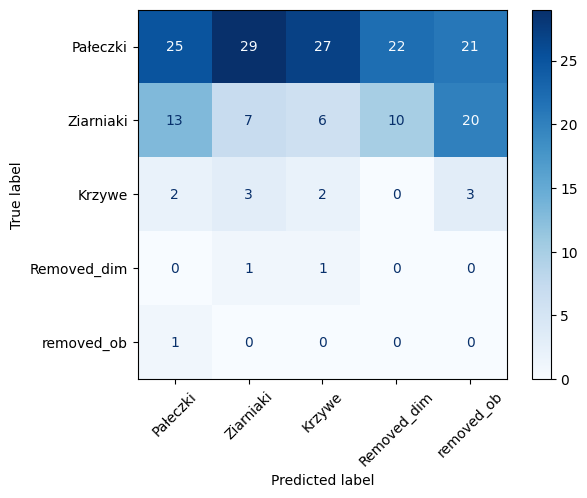

In [62]:
conf_matrix(real_df=real_df,predicted_df=predicted_df)

In [63]:
real_df[real_df['bacteria_type']=='removed_ob']

,nr.,xpix.,ypix.,xmm,ymm,powierzchniamm,dlugoscmm,szerokoscmm,kat,obwodmm,...,Pw,R,Dk,Sk,D/S,bacteria_type,Ob,bialko,wegiel,Ob_bucket
155,12,588,188,58.8,18.8,3.610738,6.06891,0.808161,169.81,20.544173,...,4.764233,1.319462,0.808161,3.811387,7.509534,removed_ob,5.271825,278.659139,239.646859,>1.0


<Axes: >

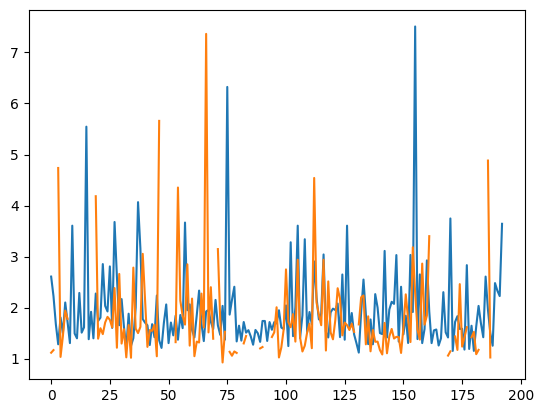

In [64]:
real_df['D/S'].plot()
predicted_df['D/S'].plot()

<Axes: >

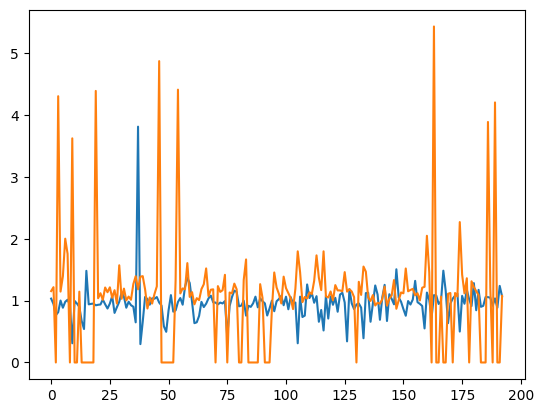

In [65]:
real_df['R'].plot()
predicted_df['R'].plot()

<Axes: >

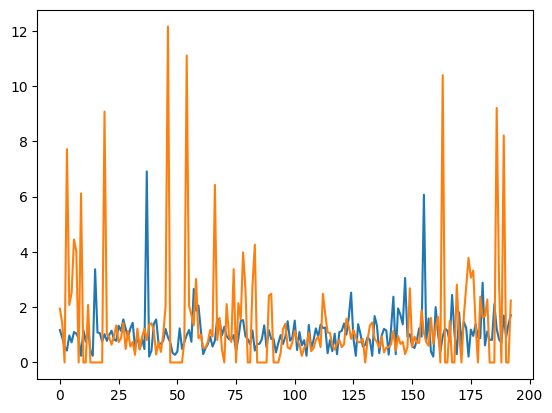

In [66]:
real_df['dlugoscmm'].plot()
predicted_df['dlugoscmm'].plot()

In [67]:
df_errors = pd.DataFrame()
df_errors['error_dlugoscmm'] = real_df['dlugoscmm']-predicted_df['dlugoscmm']
df_errors['error_szerokoscmm'] = real_df['szerokoscmm']-predicted_df['szerokoscmm']
df_errors['error_powierzchniamm'] = real_df['powierzchniamm']-predicted_df['powierzchniamm']
df_errors['error_R'] = real_df['R']-predicted_df['R']
df_errors['error_D/S'] = real_df['D/S']-predicted_df['D/S']
df_errors.corr()

,error_dlugoscmm,error_szerokoscmm,error_powierzchniamm,error_R,error_D/S
error_dlugoscmm,1.000000,0.706475,0.290247,0.857370,0.714904
error_szerokoscmm,0.706475,1.000000,0.290312,0.595749,0.117033
error_powierzchniamm,0.290247,0.290312,1.000000,-0.103449,0.303142
error_R,0.857370,0.595749,-0.103449,1.000000,0.612383
error_D/S,0.714904,0.117033,0.303142,0.612383,1.000000


In [68]:
df_real = pd.read_csv("agata_1_y_real_correct_index/raport_a3.csv")
df_predicted = pd.read_csv("no_model_agata_4/a3_raport_no_model.csv")


In [69]:
df_real

,nr.,xpix.,ypix.,xmm,ymm,powierzchniamm,długośćmm,szerokośćmm,kąt,obwódmm,...,średn._martinamm,średn._sitowamm,średnia_jaskrawość,r,g,b,y,liczenie_obiektow_w,udzial_punktow,pole_obrazu_mm2
0,2,974,882,97.4,88.2,1.21,1.476482,0.943398,61.70,3.768320,...,1.1,1.044031,225.6,105.9,156.2,166.3,141.6,30,100.0,12288.0
1,3,146,827,14.6,82.7,0.62,1.000000,0.583095,36.87,2.627664,...,0.7,0.781025,221.2,115.4,166.6,184.4,152.6,30,100.0,12288.0
2,4,1223,766,122.3,76.6,1.02,1.392839,0.824621,68.96,3.631773,...,0.9,0.800000,226.5,104.8,158.8,171.7,143.4,30,100.0,12288.0
3,5,329,720,32.9,72.0,2.21,2.220360,1.140175,35.84,5.805614,...,1.8,1.272792,226.3,124.4,164.9,187.0,154.6,30,100.0,12288.0
4,6,944,699,94.4,69.9,0.69,1.170470,0.728011,19.98,2.987016,...,1.2,0.700000,212.4,118.6,161.4,168.6,148.8,30,100.0,12288.0
5,7,719,675,71.9,67.5,1.10,1.360147,0.860233,53.97,3.559765,...,1.2,0.989949,231.9,114.2,163.9,176.7,149.8,30,100.0,12288.0
6,8,206,621,20.6,62.1,2.11,2.256103,1.104536,77.20,5.896594,...,0.9,1.100000,229.4,112.4,158.5,182.5,146.7,30,100.0,12288.0
7,9,852,616,85.2,61.6,0.35,0.670820,0.538516,26.57,1.678353,...,0.6,0.500000,207.9,118.9,160.6,151.3,146.4,30,100.0,12288.0
8,10,1215,588,121.5,58.8,0.73,1.640122,0.500000,37.57,3.934074,...,1.0,0.721110,221.2,97.9,143.0,151.4,129.7,30,100.0,12288.0
9,11,409,549,40.9,54.9,0.53,0.921954,0.640312,130.60,2.497607,...,0.9,0.700000,219.6,132.6,182.4,191.1,167.7,30,100.0,12288.0


In [70]:
df_predicted

,nr.,xpix.,ypix.,xmm,ymm,powierzchniamm,dlugoscmm,szerokoscmm,kat,obwodmm,...,sredn._martinamm,sredn._sitowamm,srednia_jaskrawosc,r,g,b,y,liczenie_obiektow_w,udzial_punktow,pole_obrazu_mm2
0,1,973.5,882.5,97.4,88.2,0.90,1.358332,0.851395,28.56,5.004163,...,1.4,1.070474,162.2,125.0,176.9,184.9,162.3,2,8.7,10.2
1,2,145.5,827.5,14.6,82.8,0.53,0.960511,0.648929,41.24,3.321320,...,1.0,0.821472,167.8,132.6,180.8,193.5,167.8,1,6.8,7.8
2,3,1222.5,766.5,122.2,76.7,0.83,1.397269,0.818105,5.77,3.931371,...,1.4,1.028002,158.2,118.9,172.9,186.1,158.3,1,8.6,9.6
3,4,328.5,720.5,32.9,72.0,1.72,2.000000,1.100000,55.71,6.935534,...,2.0,1.479855,182.3,151.7,192.8,208.5,182.3,1,12.5,13.7
4,5,943.5,699.5,94.4,70.0,0.50,1.100000,0.624753,84.95,3.331371,...,1.1,0.797885,174.6,144.8,186.2,193.4,174.6,1,5.9,8.4
5,6,718.5,675.5,71.9,67.5,0.86,1.287926,0.800000,37.63,3.531371,...,1.3,1.046416,169.2,132.7,183.1,193.6,169.2,1,8.1,10.2
6,7,205.5,621.5,20.6,62.2,1.50,2.135128,0.896240,3.78,5.862742,...,2.1,1.381977,174.9,138.9,187.6,203.4,174.8,2,10.9,13.3
7,8,851.5,616.5,85.2,61.7,0.38,0.727915,0.600000,102.63,2.131371,...,0.7,0.695580,144.6,119.6,156.0,151.1,144.6,1,5.2,6.8
8,9,1214.5,588.5,121.5,58.9,0.64,1.700000,0.639300,52.24,4.404163,...,1.7,0.902703,137.3,107.7,148.3,158.8,137.3,1,6.2,10.2
9,10,408.5,549.5,40.9,55.0,0.47,0.863964,0.667178,135.18,2.531371,...,0.9,0.773578,179.8,145.7,192.8,201.4,179.7,1,5.7,7.8


In [71]:
# df_predicted['powierzchniamm'] *= 1.1
# df_predicted['dlugoscmm'] *= 0.96
# df_predicted['szerokoscmm'] *= 0.96

In [72]:

# df_predicted['szerokoscmm'] = df_real['szerokośćmm']
# df_predicted['dlugoscmm'] = df_real['długośćmm']
# df_predicted['powierzchniamm'] = df_real['powierzchniamm']

In [73]:
# df_predicted['powierzchniamm'] = df_predicted['powierzchniamm'] *1.1

In [74]:
compared,real_df,predicted_df = compare_results(df_real=df_real,df_predicted=df_predicted,proube_volume_ml=6)
print(compared)
mean_abs_erron = np.mean(np.abs(compared['relative_error']))

real:
Shannon index: 0.7325783444855738
predicted:
Shannon index: 0.7943414591606965
  bacteria_type  count_real  count_predicted  error  relative_error
0        Krzywe           1                7      6        6.000000
1      Pałeczki          20               10    -10       -0.500000
2     Ziarniaki           3                7      4        1.333333


In [75]:
real_df['bacteria_type']

0      Pałeczki
1      Pałeczki
2      Pałeczki
3      Pałeczki
4      Pałeczki
5      Pałeczki
6      Pałeczki
7     Ziarniaki
8      Pałeczki
9     Ziarniaki
10     Pałeczki
11     Pałeczki
12    Ziarniaki
13     Pałeczki
14     Pałeczki
15       Krzywe
16     Pałeczki
17     Pałeczki
18     Pałeczki
19     Pałeczki
20     Pałeczki
21     Pałeczki
22     Pałeczki
23     Pałeczki
Name: bacteria_type, dtype: object

In [76]:
predicted_df['bacteria_type']

0      Pałeczki
1     Ziarniaki
2        Krzywe
3      Pałeczki
4        Krzywe
5      Pałeczki
6      Pałeczki
7     Ziarniaki
8        Krzywe
9     Ziarniaki
10     Pałeczki
11    Ziarniaki
12     Pałeczki
13    Ziarniaki
14       Krzywe
15       Krzywe
16    Ziarniaki
17       Krzywe
18       Krzywe
19     Pałeczki
20    Ziarniaki
21     Pałeczki
22     Pałeczki
23     Pałeczki
Name: bacteria_type, dtype: object

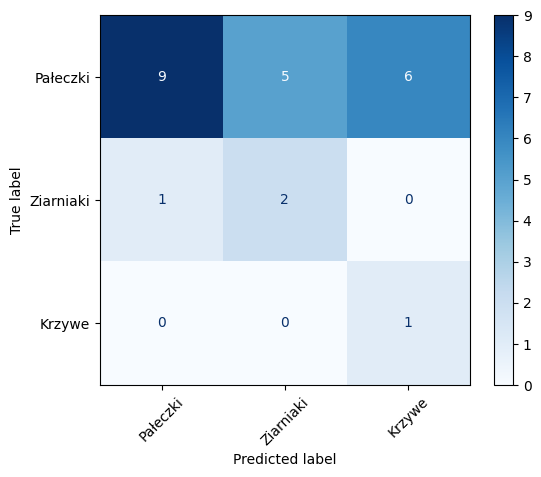

In [77]:
conf_matrix(real_df=real_df,predicted_df=predicted_df)

In [78]:
real_df[['nr.','powierzchniamm','dlugoscmm','szerokoscmm','Pw','R','D/S']]

,nr.,powierzchniamm,dlugoscmm,szerokoscmm,Pw,R,D/S
0,2,0.541387,0.990928,0.633153,0.541219,0.999690,1.565068
1,3,0.277405,0.671141,0.391339,0.229717,0.828094,1.714986
2,4,0.456376,0.934791,0.553437,0.451495,0.989305,1.689065
3,5,0.988814,1.490175,0.765218,1.014414,1.025889,1.947385
4,6,0.308725,0.785550,0.488598,0.332492,1.076984,1.607764
5,7,0.492170,0.912850,0.577337,0.455359,0.925207,1.581139
6,8,0.944072,1.514163,0.741299,1.004300,1.063797,2.042580
7,9,0.156600,0.450215,0.361420,0.134633,0.859725,1.245682
8,10,0.326622,1.100753,0.335570,0.345170,1.056786,3.280244
9,11,0.237136,0.618761,0.429740,0.226201,0.953885,1.439851


In [79]:
predicted_df[['nr.','powierzchniamm','dlugoscmm','szerokoscmm','Pw','R','D/S']]

,nr.,powierzchniamm,dlugoscmm,szerokoscmm,Pw,R,D/S
0,1,0.402685,0.911632,0.571406,0.450714,1.119273,1.595419
1,2,0.237136,0.644638,0.435523,0.239973,1.011964,1.480149
2,3,0.371365,0.937764,0.549064,0.450076,1.211952,1.707933
3,4,0.769575,1.342282,0.738255,0.873767,1.135389,1.818182
4,5,0.223714,0.738255,0.419297,0.271749,1.214718,1.760697
5,6,0.384787,0.864380,0.536913,0.402117,1.045037,1.609907
6,7,0.671141,1.432972,0.601503,0.784149,1.168382,2.382319
7,8,0.170022,0.488533,0.402685,0.161862,0.952002,1.213191
8,9,0.286353,1.140940,0.429061,0.449952,1.571318,2.659156
9,10,0.210291,0.579841,0.447770,0.216529,1.029662,1.294953


<Axes: >

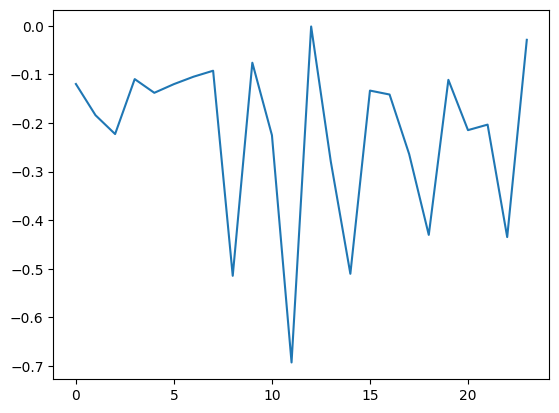

In [80]:
(real_df['R']-predicted_df['R']).plot()

<Axes: >

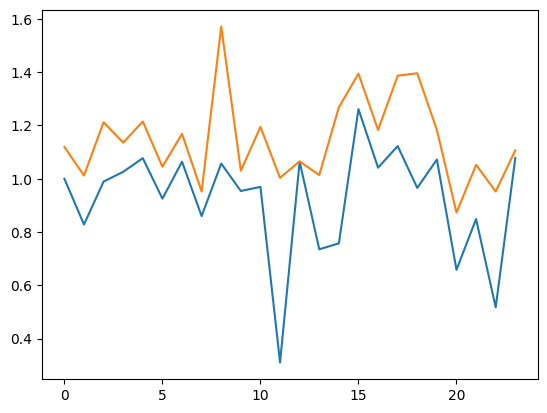

In [81]:
real_df['R'].plot()
(predicted_df['R']).plot()

<Axes: >

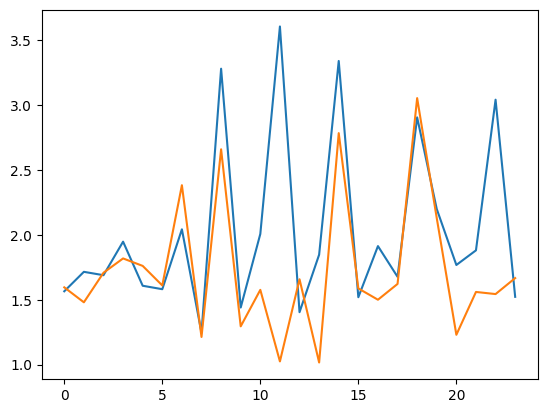

In [82]:
real_df['D/S'].plot()
predicted_df['D/S'].plot()

<Axes: >

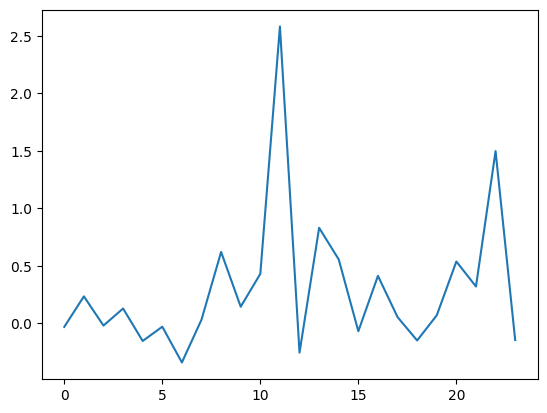

In [83]:
(real_df['D/S']-predicted_df['D/S']).plot()

<Axes: >

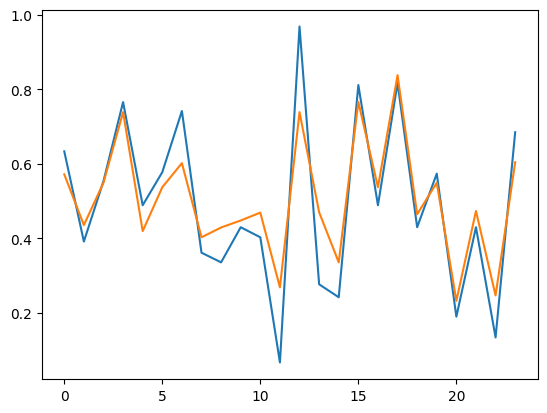

In [84]:
real_df['szerokoscmm'].plot()
(predicted_df['szerokoscmm']).plot()

<Axes: >

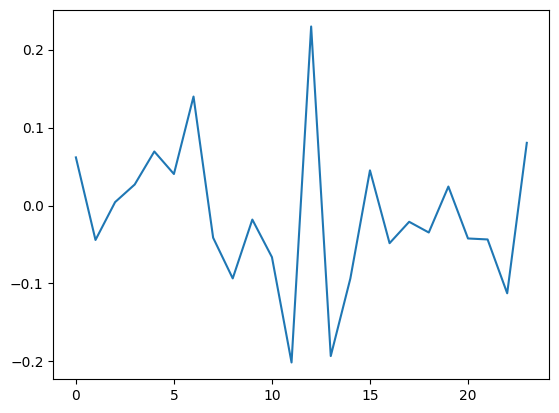

In [85]:
(real_df['szerokoscmm']-predicted_df['szerokoscmm']).plot()

<Axes: >

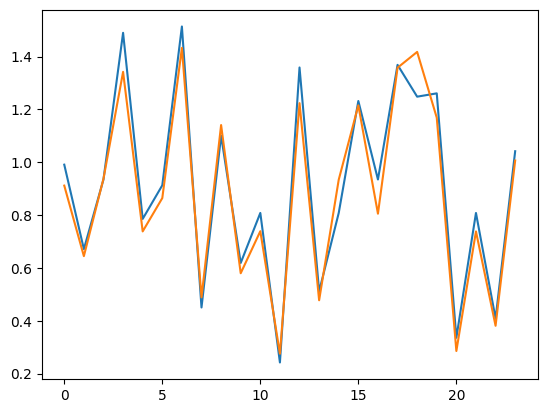

In [86]:
real_df['dlugoscmm'].plot()
(predicted_df['dlugoscmm']).plot()

<Axes: >

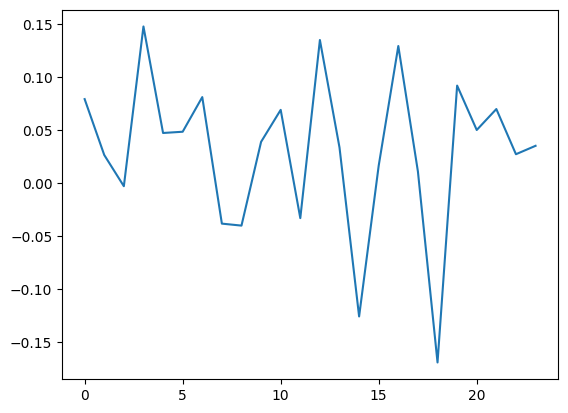

In [87]:
(real_df['dlugoscmm']-predicted_df['dlugoscmm']).plot()

<Axes: >

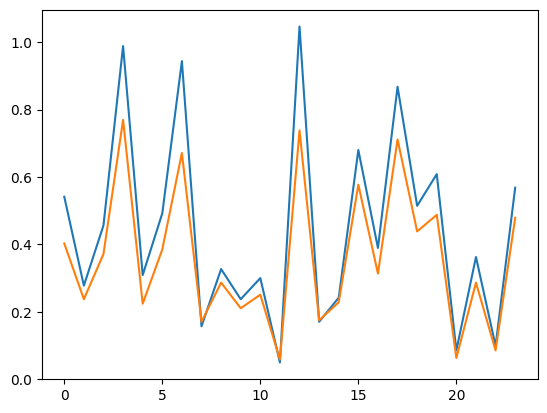

In [88]:
real_df['powierzchniamm'].plot()
(predicted_df['powierzchniamm']).plot()

<Axes: >

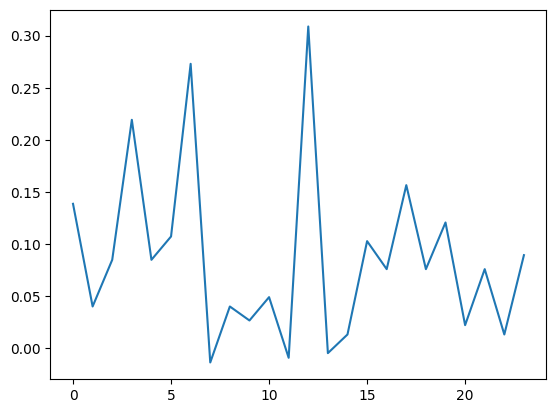

In [89]:
(real_df['powierzchniamm']-predicted_df['powierzchniamm']).plot()

In [90]:
real_df['powierzchniamm']-predicted_df['powierzchniamm']

0     0.138702
1     0.040268
2     0.085011
3     0.219239
4     0.085011
5     0.107383
6     0.272931
7    -0.013423
8     0.040268
9     0.026846
10    0.049217
11   -0.008949
12    0.308725
13   -0.004474
14    0.013423
15    0.102908
16    0.076063
17    0.156600
18    0.076063
19    0.120805
20    0.022371
21    0.076063
22    0.013423
23    0.089485
Name: powierzchniamm, dtype: float64

In [91]:
real_df['dlugoscmm']-predicted_df['dlugoscmm']

0     0.079295
1     0.026503
2    -0.002973
3     0.147893
4     0.047295
5     0.048471
6     0.081191
7    -0.038318
8    -0.040187
9     0.038920
10    0.069132
11   -0.033110
12    0.135108
13    0.033570
14   -0.125991
15    0.016528
16    0.129422
17    0.010858
18   -0.169463
19    0.092062
20    0.050122
21    0.069906
22    0.027242
23    0.035180
Name: dlugoscmm, dtype: float64

In [92]:
real_df['szerokoscmm']-predicted_df['szerokoscmm']

0     0.061747
1    -0.044184
2     0.004373
3     0.026963
4     0.069301
5     0.040425
6     0.139796
7    -0.041264
8    -0.093490
9    -0.018030
10   -0.066220
11   -0.201342
12    0.229678
13   -0.193080
14   -0.093587
15    0.045090
16   -0.048315
17   -0.020875
18   -0.034603
19    0.024348
20   -0.042271
21   -0.043518
22   -0.112593
23    0.080405
Name: szerokoscmm, dtype: float64

In [93]:
df_errors = pd.DataFrame()
df_errors['error_dlugoscmm'] = real_df['dlugoscmm']-predicted_df['dlugoscmm']
df_errors['error_szerokoscmm'] = real_df['szerokoscmm']-predicted_df['szerokoscmm']
df_errors['error_powierzchniamm'] = real_df['powierzchniamm']-predicted_df['powierzchniamm']
df_errors['error_R'] = real_df['R']-predicted_df['R']
df_errors['error_D/S'] = real_df['D/S']-predicted_df['D/S']
df_errors.corr()

,error_dlugoscmm,error_szerokoscmm,error_powierzchniamm,error_R,error_D/S
error_dlugoscmm,1.000000,0.452847,0.534316,0.662686,-0.200545
error_szerokoscmm,0.452847,1.000000,0.835005,0.747429,-0.776168
error_powierzchniamm,0.534316,0.835005,1.000000,0.517501,-0.559992
error_R,0.662686,0.747429,0.517501,1.000000,-0.768821
error_D/S,-0.200545,-0.776168,-0.559992,-0.768821,1.000000


In [94]:
for i in range(1,11):
    try:
        process_one_image(IMAGE_PATH=f'images_y/a{i}.jpg',CSV_PATH_CORRECT=f'agata_1_y_real_correct_index/raport_a{i}.csv',CSV_PATH_PREDICTED=f'no_model_agata_4/a{i}_raport_no_model.csv',OUTPUT_PATH=f'no_model_agata_4/a{i}_elipses_compare.jpg')
    except:
        continue

Image saved to no_model_agata_4/a1_elipses_compare.jpg
Image saved to no_model_agata_4/a3_elipses_compare.jpg
Image saved to no_model_agata_4/a4_elipses_compare.jpg
Image saved to no_model_agata_4/a5_elipses_compare.jpg
Image saved to no_model_agata_4/a6_elipses_compare.jpg
Image saved to no_model_agata_4/a7_elipses_compare.jpg
Image saved to no_model_agata_4/a8_elipses_compare.jpg
Image saved to no_model_agata_4/a9_elipses_compare.jpg
Image saved to no_model_agata_4/a10_elipses_compare.jpg
